In [1]:
from lsst.daf.butler import Butler

In [2]:
# Change the output collection to match your ticket, e.g. wtg/tickets/PIPE2D-1234
OUTPUT_COLLECTION = 'wtg/example'

In [3]:
# These probably dont' need to change.
DATASTORE = '/work/datastore/'
COLLECTIONS = 'PFS/default'
INSTRUMENT = 'lsst.obs.pfs.PrimeFocusSpectrograph'

# These are the pipelines that we are running.
REDUCE_PIPELINE_PATH = '$DRP_STELLA_DIR/pipelines/reduceExposure.yaml'
QA_PIPELINE_PATH = f'/work/wtg/drp_qa_dev/pipelines/detectorMapQa.yaml'

# Pipeline run options
LOG_FILE = './pipetask.log'
NUM_JOBS = 25

## Run `reduceExposure` pipeline

This will generate the `lines` and adjusted `detectorMap` objects we use for the DetectorMap QA.

We use the `!` operator to call the `pipetask` command the same as we would in a shell. 

Here we are just processing a simple set of calibration exposures, a Quartz and one of each lamp line, which we will define in our data_select string.

In [4]:
data_select = "exposure in (114641, 114644, 114647, 114651, 114655, 114659) and arm in ('b', 'r', 'n')"

In [6]:
!pipetask \
    --long-log \
    --no-log-tty \
    --log-level "pfs.drp.stella=INFO" \
    --log-file {LOG_FILE} \
    run \
    -b {DATASTORE} \
    -j {NUM_JOBS} \
    --instrument {INSTRUMENT} \
    -i {COLLECTIONS} \
    -o {OUTPUT_COLLECTION} \
    -p {REDUCE_PIPELINE_PATH} \
    -d "{data_select}"

Process task-{instrument: 'PFS', arm: 'b', spectrograph: 1, exposure: 114644, ...}:
Traceback (most recent call last):
  File "/work/stack-2024-07-11/conda/envs/lsst-scipipe-7.0.1/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/work/stack-2024-07-11/conda/envs/lsst-scipipe-7.0.1/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/work/stack-2024-07-11/conda/envs/lsst-scipipe-7.0.1/share/eups/Linux64/ctrl_mpexec/g218a3a8f53+ca4789321c/python/lsst/ctrl/mpexec/mpGraphExecutor.py", line 162, in _executeJob
    quantumExecutor.execute(taskDef, quantum)
  File "/work/stack-2024-07-11/conda/envs/lsst-scipipe-7.0.1/share/eups/Linux64/ctrl_mpexec/g218a3a8f53+ca4789321c/python/lsst/ctrl/mpexec/singleQuantumExecutor.py", line 161, in execute
    result = self._execute(taskDef, quantum)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/work/stack-2024-07-11/conda/envs/lsst-scipipe-7.0.1/

## Run `detectorMapQa` pipeline

The `detectorMapQa` runs a number of separate QA related tasks.

We specify a few options to show the syntax but the default options should be okay for most processing.

In [7]:
use_sigma = False
spatial_range = 0.1
wavelength_range = 0.1

In [10]:
!pipetask \
    --long-log \
    --no-log-tty \
    --log-file {LOG_FILE} \
    run \
    --register-dataset-types \
    -b {DATASTORE} \
    -j {NUM_JOBS} \
    --instrument {INSTRUMENT} \
    -i {COLLECTIONS} \
    -o {OUTPUT_COLLECTION} \
    -p "{QA_PIPELINE_PATH}" \
    -d "{data_select}" \
    -c dmResiduals:useSigmaRange={use_sigma} \
    -c dmResiduals:spatialRange={spatial_range} \
    -c dmResiduals:wavelengthRange={wavelength_range} \
    --fail-fast

Problem plotting residual No data
Problem plotting residual No data
Problem plotting residual No data
Problem plotting residual No data
Problem plotting residual No data
Problem plotting residual No data
Problem plotting residual No data
Problem plotting residual No data
Problem plotting residual No data
Problem plotting residual No data
Problem plotting residual No data
Problem plotting residual No data


## Get stored objects from the butler

We use the `OUTPUT_COLLECTION` to look up the objects stored by the tasks.

In [11]:
butler = Butler(DATASTORE, collections=OUTPUT_COLLECTION)


The QA task for individual exposures produces a plot (saved as a `.png` image)
and a `pandas.DataFrame` that has two rows of statistics, one for the `USED`
points and one for the `RESERVED` points.

The `USED` points come from the adjustment itself and the `RESERVED` points are
 what we want to do the QA checks on.

The statistics are stored under the `dmQaResidualStats` and the plot is `dmQaResidualPlot`. These both require the `(arm, spectrograph, exposure)` dimensions, which we define here as a traditional DataId.

In [14]:
data_id = dict(arm='r', spectrograph=2, exposure=114641)

### dmQaResidualStats

Statistics for an individual detector for a given exposure.

In [15]:
# Show the RESERVED and USED stats for the given detector exposure.
butler.get('dmQaResidualStats', data_id).T

,0,0
dof,234730.0,2113605.0
chi2X,854025.036854,7685924.863585
chi2Y,0.0,0.0
spatial.median,-0.000145,-0.000062
spatial.robustRms,0.019365,0.019363
spatial.weightedRms,0.018226,0.01822
spatial.softenFit,0.015559,0.015544
spatial.dof,234730.0,2113605.0
spatial.num_fibers,586,586
spatial.num_lines,234730,2113605


### dmQaResidualPlot

The 2D residaul plot of an indvidual detector for a given exposure.

The residual plots are stored as `png` images and the butler can only return a path to those objects, but we can display those in a notebook using the path.

In [26]:
butler.getURI('dmQaResidualPlot', data_id)

ResourcePath("file:///work/datastore/wtg/example/20241018T191142Z/dmQaResidualPlot/dmQaResidualPlot_PFS_114641_r2_wtg_example_20241018T191142Z.png")

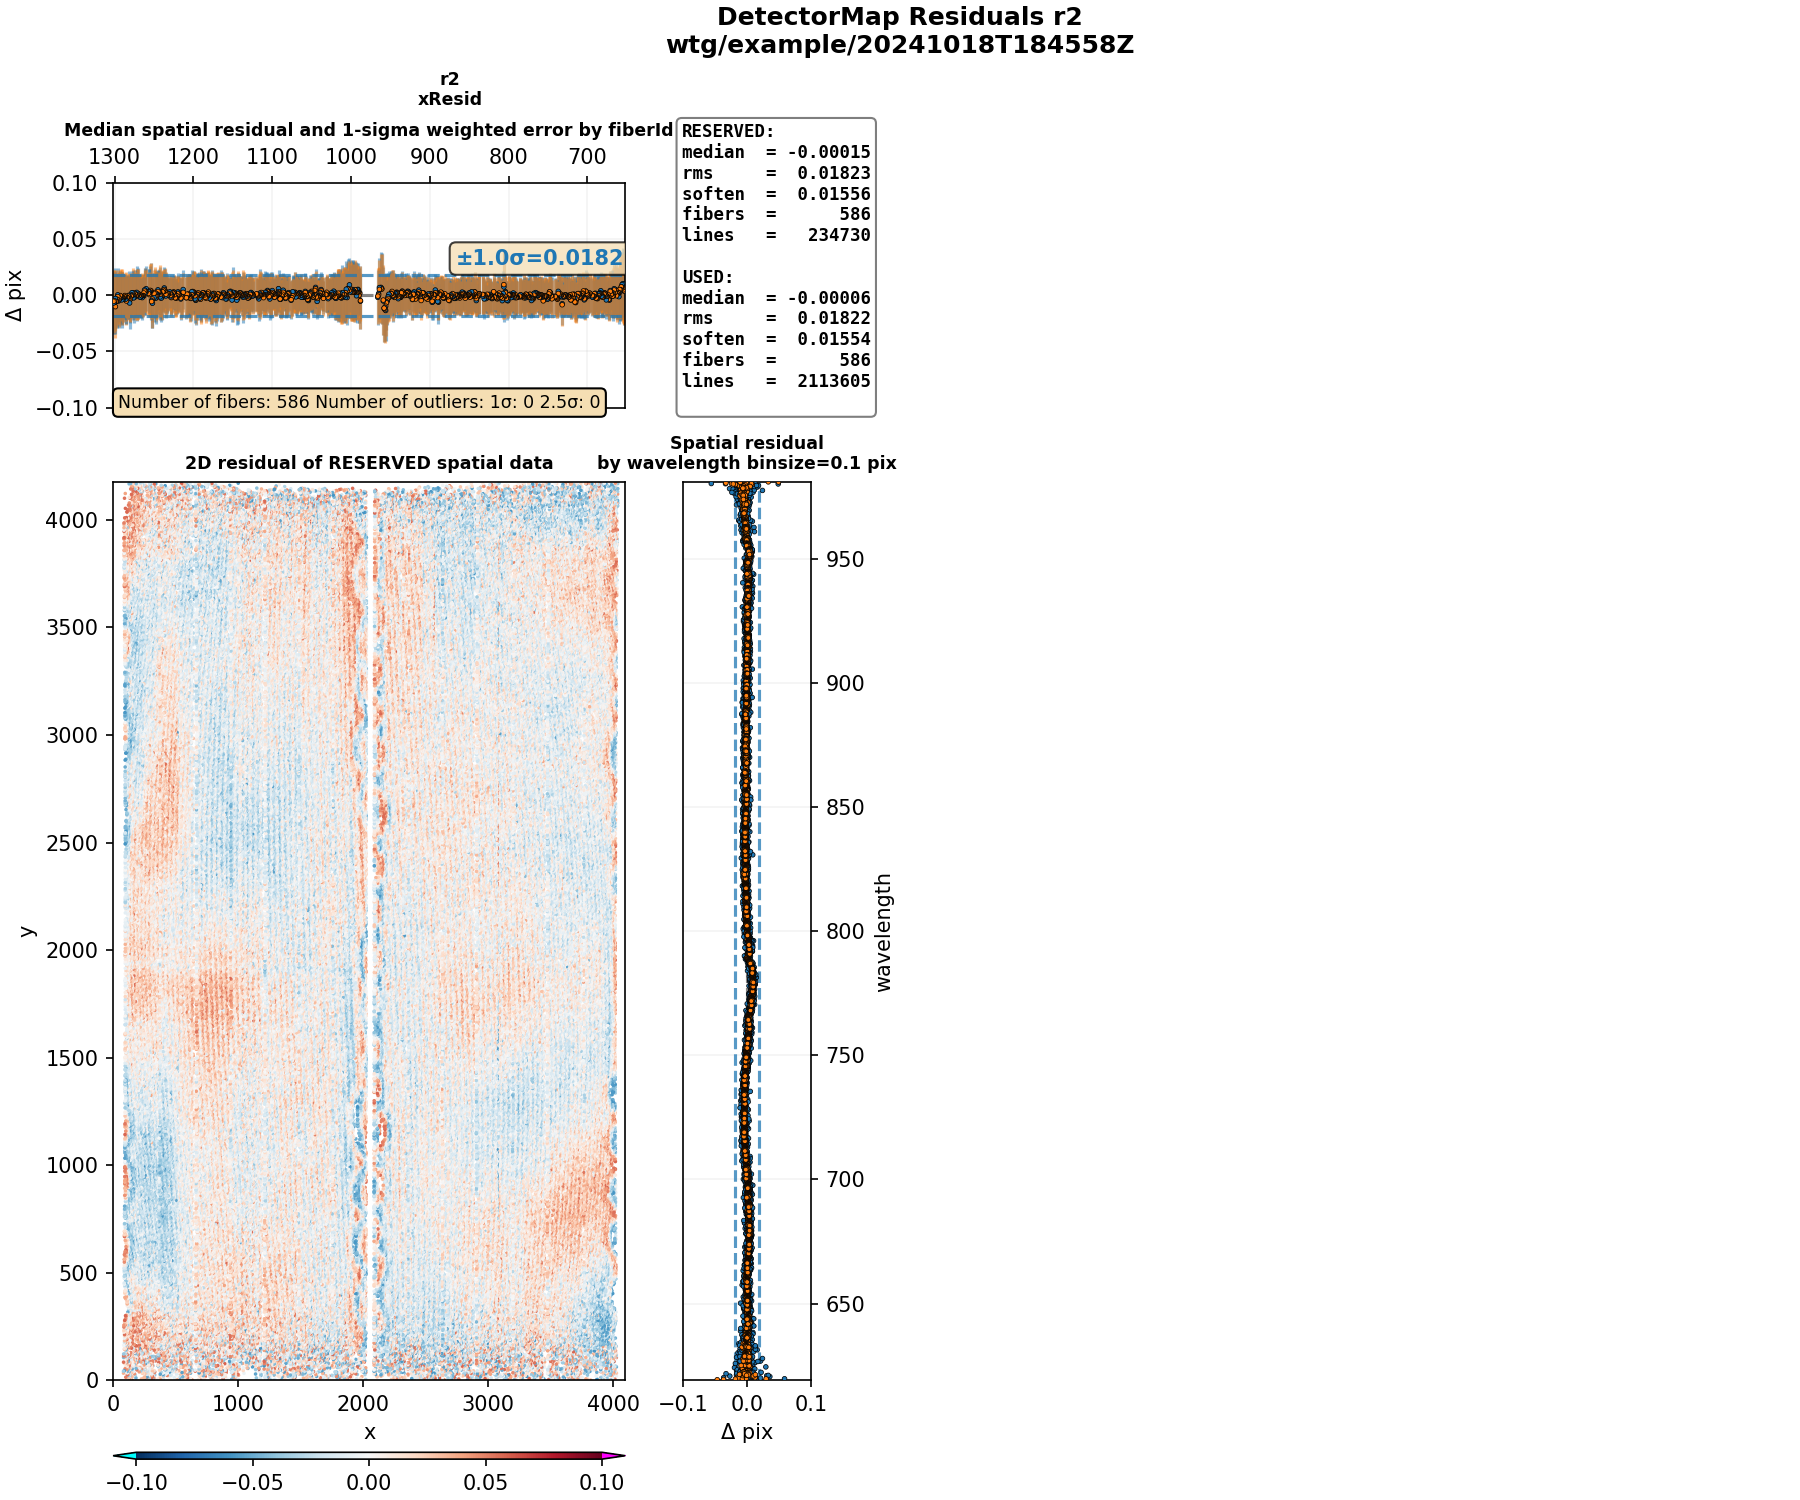

In [21]:
# Use the .unquoted_path property.
from IPython.display import Image
Image(filename=butler.getURI('dmQaResidualPlot', data_id).unquoted_path)

### dmQaDetectorStats

Aggregate detector stats for all decector and exposure combinations in the collection.

In [24]:
butler.get('dmQaDetectorStats').head()

,dof,chi2X,chi2Y,spatial.median,spatial.robustRms,spatial.weightedRms,spatial.softenFit,spatial.dof,spatial.num_fibers,spatial.num_lines,...,spectrograph,exposure,ccd,description,detector_width,detector_height,fiberId_min,fiberId_max,wavelength_min,wavelength_max
0,226062.0,8.928344e+05,0.0,0.000349,0.029218,0.026299,0.022882,226062.0,585,226062,...,1,114641,b1,Trace,4096,4176,1,651,386,659
0,226107.0,1.105196e+06,0.0,0.000205,0.030872,0.028375,0.025675,226107.0,586,226107,...,2,114641,b2,Trace,4096,4176,652,1302,384,657
0,225384.0,6.862884e+05,0.0,0.000321,0.027566,0.024532,0.020246,225384.0,596,225384,...,3,114641,b3,Trace,4096,4176,1303,1953,382,659
0,227070.0,7.425966e+05,0.0,-0.000025,0.027804,0.024906,0.020917,227070.0,587,227070,...,4,114641,b4,Trace,4096,4176,1954,2604,379,659
0,186021.0,4.510886e+06,0.0,0.000169,0.026007,0.025811,0.026181,186021.0,585,186021,...,1,114641,n1,Trace,4096,4096,1,651,929,1267


### dmQaCombinedResidualPlot

A multi-page pdf report that shows aggregate plot statistics based on the `dmQaDetectorStats` data above.

Like images, the butler cannot directly display a PDF but only return a path. We can copy that file from the datastore to the local directory to look at it.

In [25]:
butler.getURI('dmQaCombinedResidualPlot')

ResourcePath("file:///work/datastore/wtg/example/20241018T191142Z/dmQaCombinedResidualPlot/dmQaCombinedResidualPlot_PFS_wtg_example_20241018T191142Z.pdf")

In [27]:
# Copy the file to our local directory
!cp {butler.getURI('dmQaCombinedResidualPlot').unquoted_path} .